# Time-Series Classification: Dataset USC-HAD
_by Mikhail Karasikov_

In [5]:
import numpy as np
import pandas
import multiclass
import timeseries
import feature_extraction

dataset = timeseries.TSDataset()
dataset.load_from_mat('../../data/USC-HAD/USC_HAD_dataset.mat')
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame([ts.shape for ts in dataset.ts],
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 840
Stats:
       dim    len
mean    6   3347
std     0   1978
min     6    600
25%     6   2000
50%     6   3000
75%     6   4500
max     6  13500


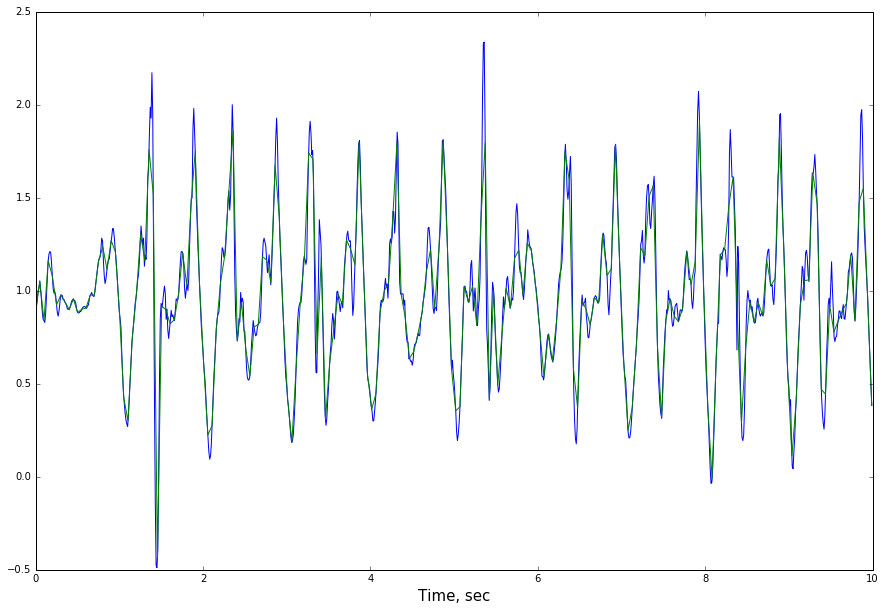

In [2]:
from matplotlib import pylab as plt
%matplotlib inline

x = dataset.ts[200][:, :1000]
t = np.arange(x.shape[1]) / 100

freq = 20
t_, x_ = timeseries.transform_frequency(t, x, freq, kind='linear')

plt.figure(figsize=(15, 10))
plt.plot(t, x[0])
plt.plot(t_, x_[0])
plt.xlabel('Time, sec', size=15)
plt.show()

## Basic Features

In [3]:
X = timeseries.ExtractFeatures(dataset.ts,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts[:3] ** 2).sum(0)).mean(),
    lambda ts: np.hstack([np.histogram(ts_1d, density=True, bins=10)[0] * (ts_1d.max() - ts_1d.min()) / 10 for ts_1d in ts]),
)
X.shape

(840, 79)

....................................................................................................
Mean accuracy: 0.824246031746
Confusion matrix:
 [[ 0.92  0.    0.    0.03  0.03  0.01  0.01  0.    0.    0.    0.    0.  ]
 [ 0.01  0.92  0.01  0.01  0.04  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.89  0.06  0.    0.02  0.02  0.    0.    0.    0.    0.  ]
 [ 0.03  0.02  0.11  0.74  0.07  0.01  0.02  0.    0.    0.    0.    0.  ]
 [ 0.05  0.08  0.    0.06  0.76  0.    0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.  ]
 [ 0.03  0.    0.    0.02  0.05  0.08  0.82  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.02  0.01  0.02  0.02]
 [ 0.    0.    0.    0.    0.    0.    0.01  0.03  0.84  0.    0.08  0.04]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.99  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.03  0.    0.56  0.4 ]
 [ 0.    0.    0.    0.  

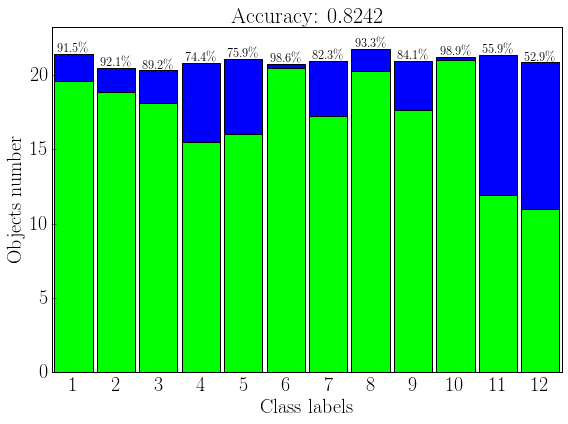

In [7]:
from sklearn import svm, cross_validation
from sklearn.multiclass import OneVsRestClassifier

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.002, C=80),
    X, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=100, test_size=0.3, random_state=17)
)

## Basic Features + AR(6) Parameters

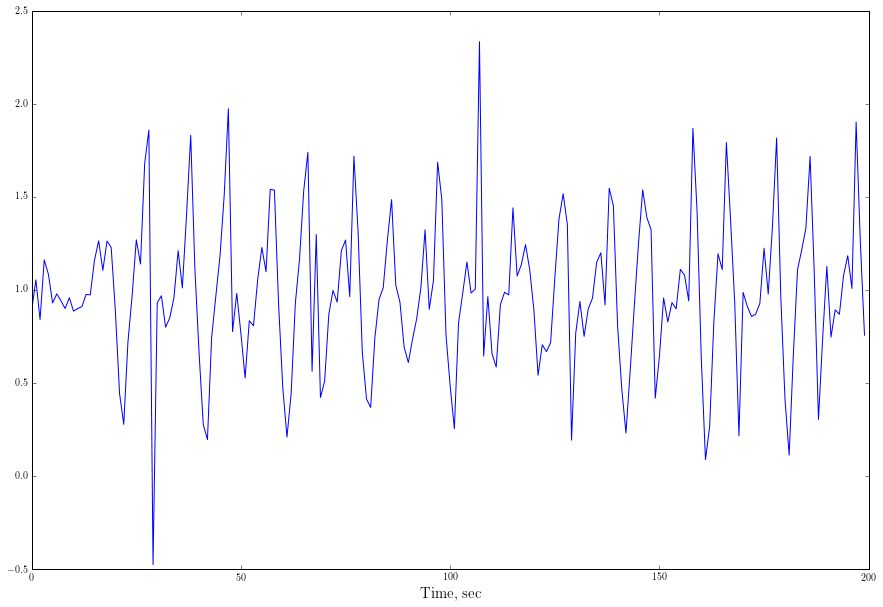

In [8]:
ts_reduced_freq = [
    timeseries.transform_frequency(np.arange(ts.shape[1]) / 100, ts, 20, kind='linear')[1]
    for ts in dataset.ts
]

plt.figure(figsize=(15, 10))
plt.plot(ts_reduced_freq[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [11]:
import sklearn

X = timeseries.ExtractFeatures(ts_reduced_freq,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
)
X.shape

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

........................................................................................................................................................................................................
Mean accuracy: 0.923412698413
Confusion matrix:
 [[ 0.93  0.01  0.04  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.01  0.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.    0.01  0.96  0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.01  0.01  0.97  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.04  0.    0.01  0.02]
 [ 0.    0.    0.    0.    0.    0.    0.    0.05  0.94  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.99  0.    0.  ]


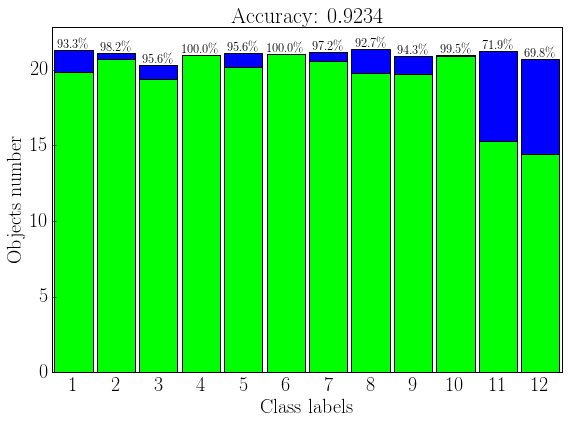

In [12]:
confusion_mean = multiclass.cross_val_score(
    OneVsRestClassifier(svm.SVC(gamma=0.1, C=16)),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=200, test_size=0.3, random_state=17)
)

## Fourier Transform

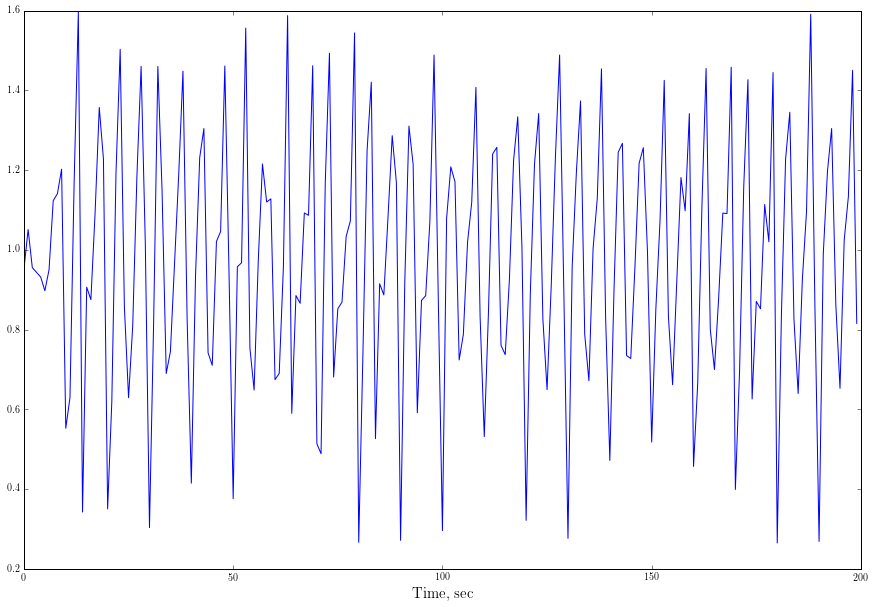

In [13]:
ts_smoothed = [
    timeseries.smooth(ts, 10)
    for ts in dataset.ts
]

plt.figure(figsize=(15, 10))
plt.plot(ts_smoothed[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [14]:
import sklearn.preprocessing

X = timeseries.ExtractFeatures(ts_smoothed,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[:3] ** 2).sum(0)), 10)[1:],
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[3:] ** 2).sum(0)), 10)[1:],
)
X.shape

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:   35.7s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:  7.2min remaining:    0.2s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:  7.3min finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.975132275132 
Best parameters: {'C': 10.0, 'gamma': 0.046415888336127774}


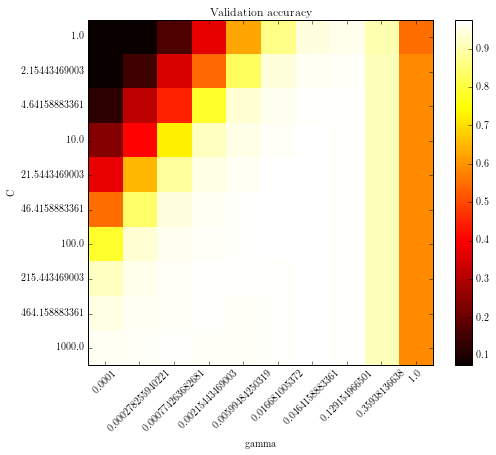

In [15]:
from sklearn.grid_search import GridSearchCV

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(0, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label.size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized, dataset.label)

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

........................................................................................................................................................................................................
Mean accuracy: 0.975734126984
Confusion matrix:
 [[ 0.97  0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.98  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.    0.01  0.95  0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.99  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.91  0.09  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.05  0.95  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]


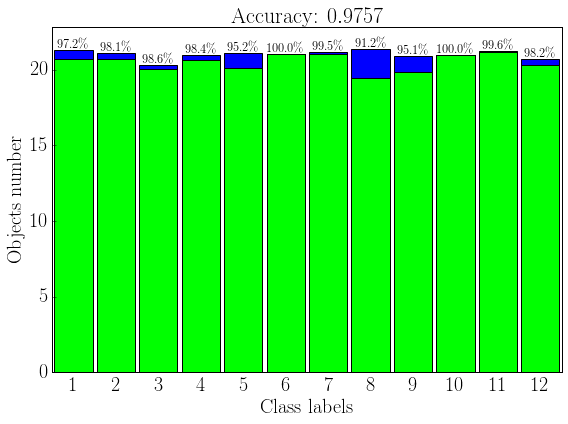

In [16]:
import multiclass
from sklearn import svm, cross_validation

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.04, C=16),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=200, test_size=0.3, random_state=17)
)

## Distribution

In [17]:
print("Stats:\n", pandas.DataFrame([ts.shape for ts in ts_smoothed],
                                   columns=['dim', 'len']).describe()[1:].round())

Stats:
       dim   len
mean    6   335
std     0   198
min     6    60
25%     6   200
50%     6   300
75%     6   450
max     6  1350


In [18]:
def split_dataset(dataset_ts, chunk_size):
    chunks, indices = [], []

    for index, ts in enumerate(dataset_ts):
        ts = np.atleast_2d(ts)
        try:
            splitted = np.hsplit(ts[:, :ts.shape[1] - ts.shape[1] % chunk_size],
                                 ts.shape[1] // chunk_size)
        except:
            splitted = [ts]
        chunks.extend(splitted)
        indices.extend([index] * len(splitted))

    return chunks, indices

chunks, indices = split_dataset(ts_smoothed, 600)

In [19]:
import sklearn.preprocessing
X = timeseries.ExtractFeatures(chunks,
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[:3] ** 2).sum(0)), 10)[1:],
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[3:] ** 2).sum(0)), 10)[1:],
)
X.shape

(846, 124)

In [20]:
import itertools

G, X_ = [], []

for k, g in itertools.groupby(zip(X, indices), lambda pair: pair[1]):
    G.append(list(zip(*g))[0])
    X_.append(np.hstack((np.mean(G[-1], 0), np.std(G[-1], 0, ddof=0))))
X_ = np.vstack(X_)

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_)

X_normalized.shape

(840, 248)

....................
Mean accuracy: 0.889523809524
Confusion matrix:
 [[ 0.94  0.03  0.02  0.01  0.01  0.    0.    0.    0.    0.  ]
 [ 0.02  0.94  0.03  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.02  0.94  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.96  0.02  0.    0.    0.    0.01  0.  ]
 [ 0.02  0.    0.    0.01  0.93  0.01  0.01  0.    0.01  0.  ]
 [ 0.    0.    0.    0.    0.01  0.99  0.01  0.    0.    0.  ]
 [ 0.01  0.    0.01  0.02  0.02  0.01  0.93  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.72  0.11  0.17]
 [ 0.    0.    0.    0.    0.    0.    0.    0.13  0.82  0.04]
 [ 0.    0.    0.    0.    0.    0.    0.    0.19  0.07  0.74]]


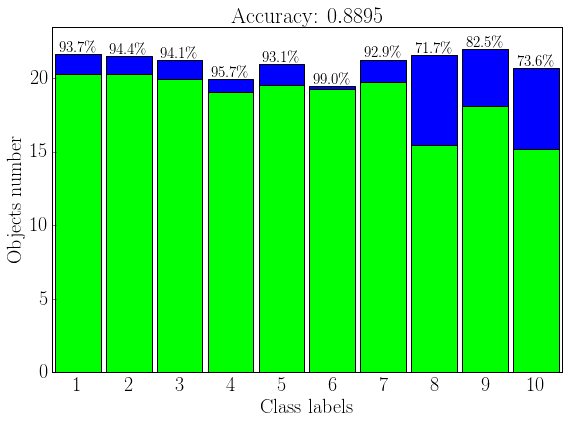

In [21]:
import multiclass
from sklearn import svm, cross_validation

confusion_mean = multiclass.cross_val_score(
    svm.SVC(kernel='linear', C=1),
    X_normalized[dataset.label <= 10], dataset.label[dataset.label <= 10],
    cross_validation.ShuffleSplit(dataset.label[dataset.label <= 10].size, n_iter=20, test_size=0.3, random_state=17)
)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:   21.3s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 748 out of 750 | elapsed:  3.1min remaining:    0.4s
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed:  3.1min finished


Fitting 30 folds for each of 25 candidates, totalling 750 fits
Best score: 0.910317460317 
Best parameters: {'C': 177.82794100389228, 'gamma': 0.01}


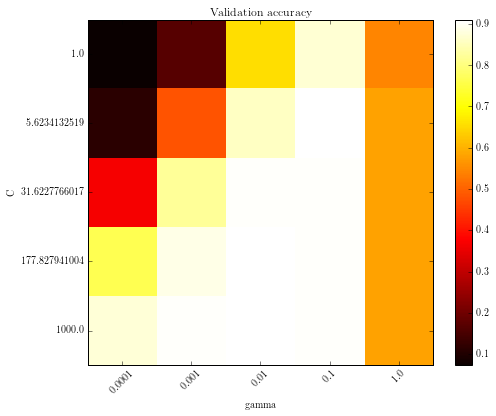

In [22]:
from sklearn.grid_search import GridSearchCV

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 5),
        'C': np.logspace(0, 3, 5),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label.size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized, dataset.label)

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)